In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sqlalchemy import create_engine, text
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
sns.set_theme(style="ticks")

# Goals of this project:

1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

2. How does direction of travel, route, or location affect the headway and on-time performance?

3. How does time of day or day of week affect headway and on-time performance?

4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [2]:
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [3]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

In [4]:
#Make new column of headway percentage by dividing headway deviation by scheduled headway
wego['HDWY_PCT'] = wego['HDWY_DEV']/wego['SCHEDULED_HDWY']
#wego['HDWY_PCT']

In [5]:
#Round HDWY_PCT to 3 decimals
wego['HDWY_PCT'] = wego['HDWY_PCT'].round(decimals=5)
#wego['HDWY_PCT']

In [6]:
#Multiply HDWY_PCT by 100 to get a more viewer friendly percentage representation
wego['HDWY_PCT'] = wego['HDWY_PCT']*100
#wego['HDWY_PCT']

In [7]:
#Break down HDWY_PCT into three columns Accpeted= >=-50% & 50%=<, Bunching=  >-50%, Gapping= 50%<
wego['BUNCHING'] = (wego['HDWY_PCT'] < -50)
wego['GAPPING'] = wego['HDWY_PCT'] > 50
wego['ACCEPTED'] = (wego['HDWY_PCT'] >= -50) & (wego['HDWY_PCT'] <= 50)

In [8]:
#Replace infinite values with NaN (then drop Nan in next step)
wego.replace([np.inf,-np. inf], np.nan, inplace=True)

In [9]:
#Drop Nan
wego.dropna(inplace=True)

In [10]:
#create headway df with our new columns and drop na
headway = wego[['ROUTE_ABBR','HDWY_DEV', 'SCHEDULED_HDWY', 'HDWY_PCT', 'ACCEPTED', 'BUNCHING', 'GAPPING']].dropna()
headway

,ROUTE_ABBR,HDWY_DEV,SCHEDULED_HDWY,HDWY_PCT,ACCEPTED,BUNCHING,GAPPING
7,22,2.666666,35.0,7.619,True,False,False
11,22,-2.166667,15.0,-14.444,True,False,False
14,22,-0.200000,60.0,-0.333,True,False,False
18,22,0.233333,15.0,1.556,True,False,False
22,22,-0.266667,63.0,-0.423,True,False,False
...,...,...,...,...,...,...,...
350305,7,-0.200000,30.0,-0.667,True,False,False
350308,7,-1.650000,30.0,-5.500,True,False,False
350311,7,0.433333,30.0,1.444,True,False,False
350317,7,-1.933334,28.0,-6.905,True,False,False


# 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [11]:
wego['ADJUSTED_ONTIME_COUNT'].value_counts()

ADJUSTED_ONTIME_COUNT
1    47280
0     5287
Name: count, dtype: int64

In [12]:
((wego['ADJUSTED_ONTIME_COUNT'].sum()/350329)*100).round(decimals=2)

13.5

# 77.08% 0f departures are "on-time" (no more than 6 min late or 1 min early)

In [13]:
# Calculate Adherence mean and standard deviation
ad_mean = wego['ADHERENCE'].mean()
ad_std = np.std(wego['ADHERENCE'])

[Text(0.5, 1.0, 'Adherence Distribution'), Text(0.5, 0, 'Adherence')]

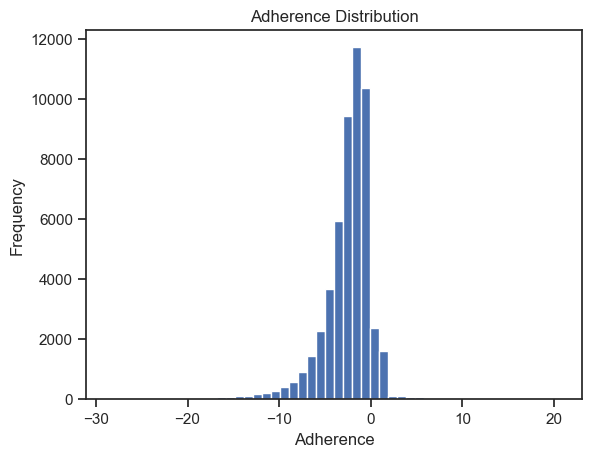

In [14]:
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50)
)

ax.set(
    title='Adherence Distribution',
    xlabel='Adherence'
    )

In [15]:
# Calculate Adherence mean and standard deviation
hdpct_mean = wego['HDWY_PCT'].mean()
hdpct_std = np.std(wego['HDWY_PCT'])

[Text(0.5, 1.0, 'Headway Percentage Distribution'),
 Text(0.5, 0, 'Headway Percentage')]

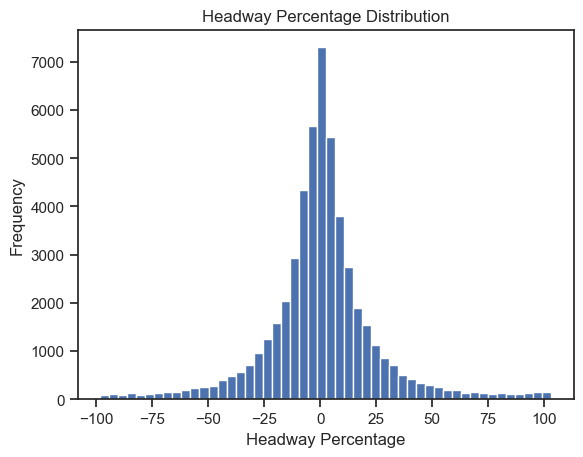

In [16]:
ax = (
    wego[wego['HDWY_PCT'].between(hdpct_mean - hdpct_std*3,
                                   hdpct_mean + hdpct_std*3,
                                   inclusive='both')]
    ['HDWY_PCT']
    .plot(kind='hist',
          bins=50)
)

ax.set(
    title='Headway Percentage Distribution',
    xlabel='Headway Percentage'
    )

# 2. How does direction of travel, route, or location affect the headway and on-time performance?

In [17]:
wego.groupby('ROUTE_DIRECTION_NAME')[['ADHERENCE', 'HDWY_PCT']].describe()

ADHERENCE                                            \
                         count      mean       std         min       25%   
ROUTE_DIRECTION_NAME                                                       
FROM DOWNTOWN          26185.0 -3.246578  9.576713 -948.533333 -4.083333   
TO DOWNTOWN            26382.0 -2.262030  7.665999 -618.166666 -2.883333   

                                                    HDWY_PCT            \
                           50%       75%        max    count      mean   
ROUTE_DIRECTION_NAME                                                     
FROM DOWNTOWN        -2.416666 -1.166666  68.433333  26185.0  2.611339   
TO DOWNTOWN          -1.600000 -0.733333  84.666666  26382.0  2.266092   

                                                                         
                            std    min     25%    50%     75%       max  
ROUTE_DIRECTION_NAME                                                     
FROM DOWNTOWN         39.490168 -100.0 -12.917  0.250  14.028  1442.500  
TO DOWNTOWN           26.453613 -100.0  -7.000  0.028   7.722   796.611

# In-bound has a slightly better ADHERENCE and HEADWAY PERCENTAGE (HDWY_PCT).

In [18]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE', 'HDWY_PCT']].describe()

ADHERENCE                                                       \
               count      mean        std         min       25%       50%   
ROUTE_ABBR                                                                  
3             6242.0 -2.907981   3.331624 -112.416666 -3.850000 -2.383333   
7             4276.0 -2.310243   4.762489  -39.166666 -2.920833 -1.683333   
22            5667.0 -1.720387   9.435801 -675.000000 -2.675000 -1.183333   
23            6997.0 -2.714111  14.689377 -618.166666 -3.150000 -1.883333   
50            6000.0 -2.638536   2.646061  -56.050000 -3.700000 -2.266666   
52            6873.0 -3.456307  13.343292 -948.533333 -4.133333 -2.166666   
55            8321.0 -3.444391   7.176213 -375.233333 -3.833333 -2.083333   
56            8191.0 -2.401544   3.020756 -114.066666 -3.616666 -1.900000   

                                HDWY_PCT                                \
                 75%        max    count      mean        std      min   
ROUTE_ABBR                                                               
3          -1.416666  17.466666   6242.0  3.921510  47.289079 -100.000   
7          -0.883333  84.666666   4276.0  1.575644  26.914119  -99.667   
22         -0.050000  20.333333   5667.0  1.791489  25.998045  -99.444   
23         -0.933333  33.633333   6997.0  5.156664  32.387893  -99.444   
50         -0.950000  19.950000   6000.0  0.673869  22.791228  -99.444   
52         -1.000000  24.400000   6873.0  2.616199  33.304415  -99.556   
55         -1.033333  13.566666   8321.0  1.973806  39.149322 -100.000   
56         -0.766666  39.916666   8191.0  1.497313  30.232029  -99.603   

                                                
                25%    50%       75%       max  
ROUTE_ABBR                                      
3           -7.6790  0.417   9.11100  1442.500  
7           -6.4685  0.000   6.68075   357.500  
22          -6.3330  0.000   6.38900   796.611  
23          -8.2500  0.694  11.52800   325.600  
50          -9.8890 -0.167   9.50000   228.000  
52          -9.3330  0.333  10.71400   356.333  
55         -14.5000 -0.167  14.63000   343.556  
56         -12.6670  0.333  13.83300   298.833

Route 22 (Bordeaux) has the best ADHERENCE while Route 50 (Charlotte Pike) has best HEADWAY PERCENTAGE (HDWY_PCT).

In [19]:
by_stop_location = wego.groupby('BLOCK_ABBR')[['ADHERENCE', 'HDWY_PCT']].describe()
by_stop_location

ADHERENCE                                                     \
               count      mean       std        min       25%       50%   
BLOCK_ABBR                                                                
300           1211.0 -2.743806  3.314086 -61.033333 -3.633333 -2.216666   
301            896.0 -2.411774  3.337985 -41.750000 -3.137500 -1.900000   
302            117.0 -3.857265  1.638254  -8.500000 -5.016666 -3.583333   
303            846.0 -4.141253  3.790118 -58.050000 -5.533333 -3.700000   
304             96.0 -2.757812  4.234790 -35.783333 -3.879166 -2.341667   
...              ...       ...       ...        ...       ...       ...   
5607           715.0 -2.128275  2.758808 -31.050000 -3.141666 -1.683333   
5608           666.0 -2.160085  2.413901 -21.000000 -3.133333 -1.658333   
5609           502.0 -2.844621  3.213923 -20.100000 -4.366666 -2.366666   
5610           666.0 -2.726451  2.579219 -15.066666 -4.262499 -2.133333   
5611           296.0 -3.185811  2.388410 -13.816666 -4.583333 -3.024999   

                                HDWY_PCT                                 \
                 75%        max    count       mean        std      min   
BLOCK_ABBR                                                                
300        -1.216666   9.366666   1211.0  -0.417994  22.210180 -100.000   
301        -1.162500  17.466666    896.0   0.026622  25.636703  -98.500   
302        -2.700000  -0.433333    117.0  14.122718  26.347424  -50.111   
303        -2.350000   6.550000    846.0  10.212266  23.786005  -99.000   
304        -1.491667   6.666666     96.0   2.469635  36.495342  -82.667   
...              ...        ...      ...        ...        ...      ...   
5607       -0.416666   9.300000    715.0  -3.807101  26.718437  -97.833   
5608       -1.033333  19.650000    666.0   3.157119  24.739314  -95.000   
5609       -0.691666  16.216666    502.0   6.009094  35.386629  -99.333   
5610       -1.150000   8.800000    666.0   3.882550  28.205981  -99.333   
5611       -1.562499   6.266666    296.0  13.409361  34.316628  -85.500   

                                                  
                 25%      50%       75%      max  
BLOCK_ABBR                                        
300         -9.38200  -1.3330   6.56650  156.917  
301         -9.00000  -0.6875   7.02075  208.167  
302          0.88900  11.9440  21.00000  145.556  
303          0.06350   8.2330  17.08325  144.470  
304        -13.33350   0.8750  10.70850  156.250  
...              ...      ...       ...      ...  
5607       -17.52800  -3.0000   7.81950  126.296  
5608        -8.16700   2.1250  13.62525  143.667  
5609       -11.62525   4.2780  24.50000  167.167  
5610        -9.62350   1.7445  17.12525  131.000  
5611        -7.66675  11.2500  30.54175  154.167  

[85 rows x 16 columns]

In [20]:
by_stop_location_ad = by_stop_location.sort_values(('ADHERENCE', 'mean'), ascending=False)
by_stop_location_ad

ADHERENCE                                                       \
               count      mean        std         min       25%       50%   
BLOCK_ABBR                                                                  
2210          1076.0 -0.756010   2.476665  -48.366666 -1.633333 -0.133333   
2211          1081.0 -1.423157  20.579074 -675.000000 -1.466666 -0.516666   
700            930.0 -1.509355   7.763577  -30.966666 -2.666666 -1.800000   
2200          1480.0 -1.728266   3.705339  -77.433333 -2.650000 -1.458333   
313            364.0 -1.937729   1.642317  -12.466666 -2.408333 -1.666666   
...              ...       ...        ...         ...       ...       ...   
5206            37.0 -5.417117   5.462510  -23.866666 -7.400000 -4.250000   
5512           122.0 -5.437431   7.878329  -57.766666 -5.870833 -2.941667   
5511           395.0 -5.505991  10.446328 -121.900000 -5.666666 -3.183333   
5218            36.0 -5.884259   8.974197  -42.533333 -4.412500 -2.316666   
5513            38.0 -6.950000   9.164068  -47.083333 -7.516666 -3.800000   

                                HDWY_PCT                                \
                 75%        max    count       mean        std     min   
BLOCK_ABBR                                                               
2210        0.683333  15.933333   1076.0  -3.695083  23.028002 -98.974   
2211        0.183333  19.750000   1081.0  -3.766348  26.104259 -91.667   
700        -0.937500  84.666666    930.0   2.033255  26.947726 -99.111   
2200       -0.133333  15.416666   1480.0   3.391059  28.110165 -99.444   
313        -0.958333   2.233333    364.0  -7.076750  25.197925 -99.167   
...              ...        ...      ...        ...        ...     ...   
5206       -1.550000   1.600000     37.0  12.108081  64.405482 -96.833   
5512       -1.616667   3.900000    122.0 -10.485221  50.653135 -98.833   
5511       -1.550000   8.283333    395.0  15.167213  44.098698 -94.000   
5218       -1.795833   0.100000     36.0   0.486139  61.554378 -89.333   
5513       -2.112500   0.966666     38.0 -14.631605  56.222142 -92.167   

                                                 
                 25%     50%       75%      max  
BLOCK_ABBR                                       
2210       -11.92300  -4.467   2.33300  172.564  
2211       -13.20500  -1.333   4.86700  500.267  
700         -7.43725  -0.414   6.87500  264.167  
2200        -4.00700   0.028   5.80825  796.611  
313        -15.40000  -5.778  -0.08325  146.167  
...              ...     ...       ...      ...  
5206       -15.50000   4.333  41.83300  169.000  
5512       -42.41675 -11.139  12.95875  150.167  
5511        -7.83350  10.333  36.94450  214.667  
5218       -51.29200   0.167  30.54175  115.333  
5513       -60.91675 -19.000  13.87475  143.333  

[85 rows x 16 columns]

In [21]:
(
    wego
    .loc[wego['BLOCK_ABBR'] == 2210]
    [['ROUTE_ABBR', 'BLOCK_ABBR', 'ADHERENCE', 'ROUTE_DIRECTION_NAME']]
)

,ROUTE_ABBR,BLOCK_ABBR,ADHERENCE,ROUTE_DIRECTION_NAME
318,22,2210,-2.866666,FROM DOWNTOWN
321,22,2210,-2.033333,TO DOWNTOWN
324,22,2210,-2.133333,FROM DOWNTOWN
327,22,2210,-2.183333,TO DOWNTOWN
330,22,2210,-1.400000,FROM DOWNTOWN
...,...,...,...,...
340006,22,2210,0.950000,TO DOWNTOWN
340009,22,2210,-1.583333,FROM DOWNTOWN
340015,22,2210,-2.216666,FROM DOWNTOWN
340018,22,2210,0.733333,TO DOWNTOWN


# Bus Stop 2210 (BLOCK_ABBR) of Route 22 (Bordeaux) In-Bound has the best ADHERENCE.

In [22]:
location_hdwypct_pos = wego[wego['HDWY_PCT'] > 0]
location_hdwypct_pos = location_hdwypct_pos.sort_values('HDWY_PCT')
location_hdwypct_pos = location_hdwypct_pos[['BLOCK_ABBR', 'HDWY_PCT']]
location_hdwypct_pos

,BLOCK_ABBR,HDWY_PCT
13008,2200,0.025
339727,2200,0.025
167933,2200,0.025
87119,2200,0.025
93638,2200,0.025
...,...,...
129465,316,815.833
163370,316,880.000
156908,316,956.667
288308,316,1111.667


In [23]:
location_hdwypct_neg = wego[wego['HDWY_PCT'] < 0]
location_hdwypct_neg = location_hdwypct_neg.sort_values(['HDWY_PCT'], ascending=[False])
location_hdwypct_neg = location_hdwypct_neg[['BLOCK_ABBR', 'HDWY_PCT']]
location_hdwypct_neg

,BLOCK_ABBR,HDWY_PCT
6558,2200,-0.025
46742,2200,-0.025
292866,2200,-0.025
320221,2200,-0.025
252416,2200,-0.025
...,...,...
65979,703,-99.667
44507,5505,-99.667
249878,5501,-99.833
30822,300,-100.000


In [24]:
(
    wego
    .loc[wego['BLOCK_ABBR'] == 2200]
    [['ROUTE_ABBR', 'BLOCK_ABBR', 'HDWY_PCT', 'ROUTE_DIRECTION_NAME']]
)

,ROUTE_ABBR,BLOCK_ABBR,HDWY_PCT,ROUTE_DIRECTION_NAME
7,22,2200,7.619,TO DOWNTOWN
11,22,2200,-14.444,FROM DOWNTOWN
14,22,2200,-0.333,TO DOWNTOWN
18,22,2200,1.556,FROM DOWNTOWN
22,22,2200,-0.423,TO DOWNTOWN
...,...,...,...,...
346266,22,2200,1.397,TO DOWNTOWN
346269,22,2200,-1.556,FROM DOWNTOWN
346272,22,2200,-0.444,TO DOWNTOWN
346275,22,2200,1.278,FROM DOWNTOWN


# Bus Stop 2200 (BLOCK_ABBR) also of Route 22 (Bordeaux) In-Bound has the best HEADWAY PERCENTAGE.

# 3. How does time of day or day of week affect headway and on-time performance?

In [25]:
#convert scheduled time from object to datetime
wego['SCHEDULED_TIME'] = pd.to_datetime(wego['SCHEDULED_TIME'])

In [26]:
#create column for day of the week using scheduled time column
wego['DAY_OF_WEEK'] = wego['SCHEDULED_TIME'].dt.day_name()

In [27]:
#looking at average adherence and hdwy_dev by day
dweek_adhdwy = wego[['DAY_OF_WEEK' , "HDWY_DEV", "ADHERENCE"]].groupby(['DAY_OF_WEEK']).mean("HDWY_DEV", "ADHERENCE").reset_index()
dweek_adhdwy

,DAY_OF_WEEK,HDWY_DEV,ADHERENCE
0,Friday,0.478923,-3.138254
1,Monday,0.197465,-2.326996
2,Saturday,0.393563,-3.020308
3,Sunday,0.956005,-3.037243
4,Thursday,0.452072,-2.797529
5,Tuesday,0.310937,-2.495021
6,Wednesday,0.256684,-2.636548


In [28]:
#bunchimg, gapping, accepted summation by day
dweek_hdwy = wego[['DAY_OF_WEEK', "BUNCHING", "GAPPING", "ACCEPTED"]].groupby(['DAY_OF_WEEK']).agg('sum').reset_index()
dweek_hdwy

,DAY_OF_WEEK,BUNCHING,GAPPING,ACCEPTED
0,Friday,400,612,7692
1,Monday,205,292,7025
2,Saturday,92,152,5331
3,Sunday,59,177,4116
4,Thursday,361,566,7848
5,Tuesday,328,470,7972
6,Wednesday,317,439,8113


In [29]:
#looking at average adherence and hdwy_dev by day
dweek_adhdwy = wego[['DAY_OF_WEEK' , "HDWY_DEV", "ADHERENCE"]].groupby(['DAY_OF_WEEK']).mean("HDWY_DEV", "ADHERENCE").reset_index()
dweek_adhdwy

,DAY_OF_WEEK,HDWY_DEV,ADHERENCE
0,Friday,0.478923,-3.138254
1,Monday,0.197465,-2.326996
2,Saturday,0.393563,-3.020308
3,Sunday,0.956005,-3.037243
4,Thursday,0.452072,-2.797529
5,Tuesday,0.310937,-2.495021
6,Wednesday,0.256684,-2.636548


In [30]:
#bunchimg, gapping, accepted summation by day
dweek_hdwy = wego[['DAY_OF_WEEK', "BUNCHING", "GAPPING", "ACCEPTED"]].groupby(['DAY_OF_WEEK']).agg('sum').reset_index()
dweek_hdwy

,DAY_OF_WEEK,BUNCHING,GAPPING,ACCEPTED
0,Friday,400,612,7692
1,Monday,205,292,7025
2,Saturday,92,152,5331
3,Sunday,59,177,4116
4,Thursday,361,566,7848
5,Tuesday,328,470,7972
6,Wednesday,317,439,8113


In [31]:
#adherence variances summation based on day of week
dweek_adherence = wego[['DAY_OF_WEEK', "ADJUSTED_EARLY_COUNT", "ADJUSTED_LATE_COUNT", "ADJUSTED_ONTIME_COUNT"]].groupby(['DAY_OF_WEEK']).agg('sum').reset_index()
dweek_adherence

,DAY_OF_WEEK,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,Friday,135,897,7672
1,Monday,87,496,6939
2,Saturday,54,582,4939
3,Sunday,39,347,3966
4,Thursday,95,828,7852
5,Tuesday,116,751,7903
6,Wednesday,95,765,8009


# 4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

In [32]:
operator_adherence_ontime = wego[['OPERATOR', "ADJUSTED_ONTIME_COUNT"]].groupby(['OPERATOR']).agg('sum')
operator_adherence_ontime = operator_adherence_ontime.sort_values(['ADJUSTED_ONTIME_COUNT'], ascending=[False]).reset_index()
operator_adherence_ontime

,OPERATOR,ADJUSTED_ONTIME_COUNT
0,1762,716
1,1761,603
2,1170,483
3,379,477
4,1040,439
...,...,...
323,3077,1
324,375,1
325,2094,1
326,235,1


In [33]:
operator_adherence_late = wego[['OPERATOR', "ADJUSTED_LATE_COUNT"]].groupby(['OPERATOR']).agg('sum')
operator_adherence_late = operator_adherence_late.sort_values(['ADJUSTED_LATE_COUNT'], ascending=[False]).reset_index()
operator_adherence_late

,OPERATOR,ADJUSTED_LATE_COUNT
0,1800,133
1,2109,91
2,1204,82
3,2783,78
4,2312,76
...,...,...
323,1938,0
324,2675,0
325,1915,0
326,3035,0


In [34]:
operator_adherence_early = wego[['OPERATOR', "ADJUSTED_EARLY_COUNT"]].groupby(['OPERATOR']).agg('sum')
operator_adherence_early = operator_adherence_early.sort_values(['ADJUSTED_EARLY_COUNT'], ascending=[False]).reset_index()
operator_adherence_early

,OPERATOR,ADJUSTED_EARLY_COUNT
0,1147,17
1,2783,16
2,3144,13
3,1237,13
4,1368,13
...,...,...
323,2309,0
324,2313,0
325,2322,0
326,2332,0


# 5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [35]:
(wego['ADJUSTED_LATE_COUNT'].corr(wego['HDWY_PCT'])).round(decimals=2)

0.26

The correlation coefficicient of .26 shows a positive linear relationship between lateness and headway deviation percentage. When one increases, so does the other.